#### 3D Map

While representing the configuration space in 3 dimensions isn't entirely practical it's fun (and useful) to visualize things in 3D.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline 

In [2]:
plt.rcParams['figure.figsize'] = 16, 16
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


In [5]:
def create_voxmap(data, voxel_size=5):
    """
    Returns a grid representation of a 3D configuration space
    based on given obstacle data.
    
    The `voxel_size` argument sets the resolution of the voxel map. 
    """
    # minimum and maximum north coordinates
    north_min = np.floor(np.amin(data[:, 0] - data[:, 3]))
    north_max = np.ceil(np.amax(data[:, 0] + data[:, 3]))
    # minimum and maximum east coordinates
    east_min = np.floor(np.amin(data[:, 1] - data[:, 4]))
    east_max = np.ceil(np.amax(data[:, 1] + data[:, 4]))
    alt_max = np.ceil(np.amax(data[:, 2] + data[:, 5]))
    # given the minimum and maximum coordinates we can
    # calculate the size of the grid.
    north_size = int(np.ceil((north_max - north_min))) // voxel_size
    east_size = int(np.ceil((east_max - east_min))) // voxel_size
    alt_size = int(alt_max) // voxel_size
    
    voxmap = np.zeros((north_size, east_size, alt_size), dtype=np.bool)
    
    for i in range(data.shape[0]):
        #continue
        # TODO: fill in the voxels that are part of an obstacle with `True`
        #
        # i.e. grid[0:5, 20:26, 2:7] = True
        north, east, alt, d_north, d_east, d_alt = data[i, :]
        obstacle = [
            int(north-d_north-north_min)//voxel_size,
            int(north+d_north-north_min)//voxel_size,
            int(east-d_east-east_min)//voxel_size,
            int(east+d_east-east_min)//voxel_size,
        ]
        height=int(alt+d_alt)//voxel_size
        voxmap[obstacle[0]:obstacle[1], obstacle[2]:obstacle[3], 0:height]=True
        
    return voxmap    

In [7]:
voxmap=create_voxmap(data, 10)
print(voxmap.shape)
print(voxmap)

(92, 92, 21)
[[[ True  True  True ... False False False]
  [ True  True  True ... False False False]
  [ True  True  True ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[ True  True  True ... False False False]
  [ True  True  True ... False False False]
  [ True  True  True ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[ True  True  True ... False False False]
  [ True  True  True ... False False False]
  [ True  True  True ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 ...

 [[ True  True  True ... False False False]
  [ True  True  True ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... Fa

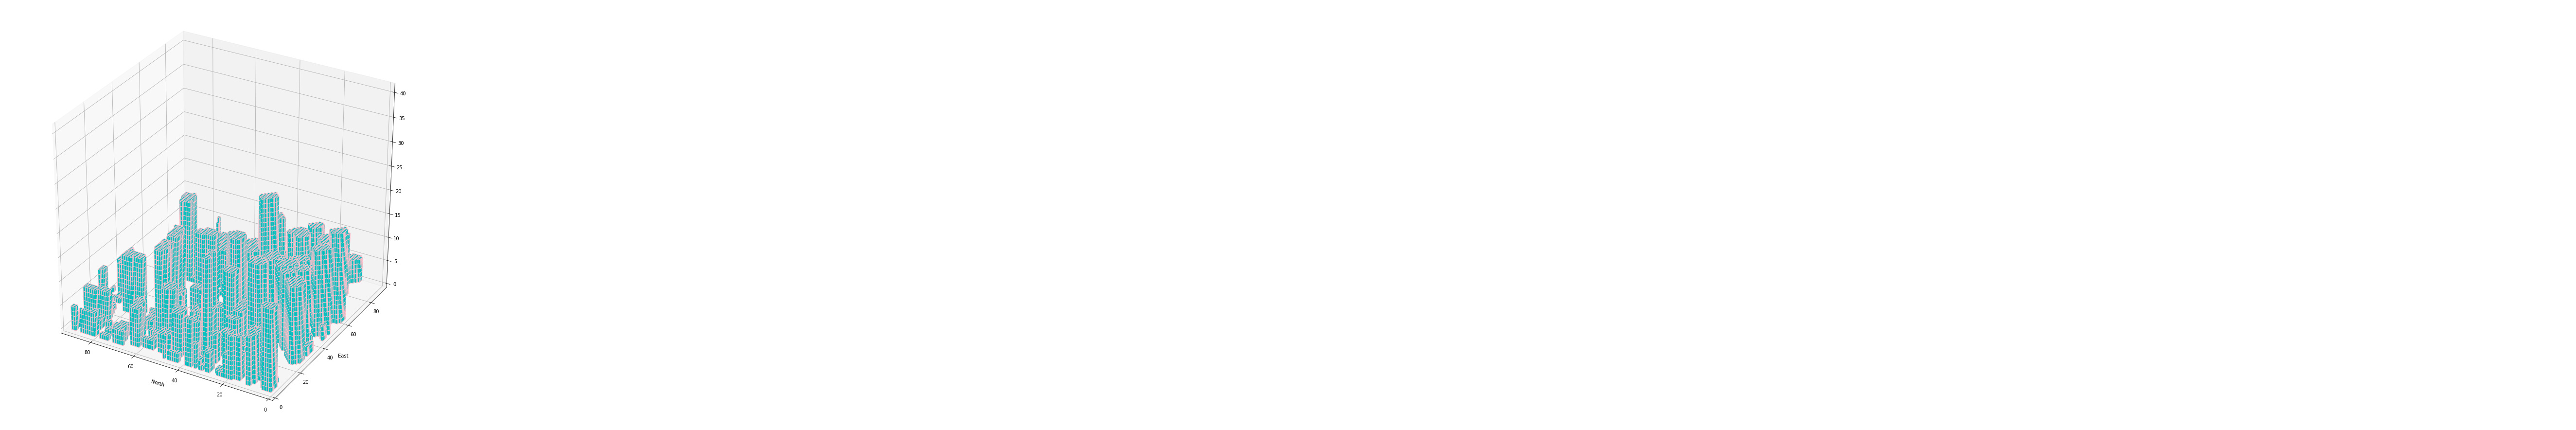

In [13]:
fig=plt.figure()
ax=fig.gca(projection='3d')
ax.voxels(voxmap, edgecolor='pink', facecolors='c')
ax.set_xlim(voxmap.shape[0], 0)
ax.set_ylim(0, voxmap.shape[1])
ax.set_zlim(0, voxmap.shape[2]+20)
plt.xlabel('North')
plt.ylabel('East')
plt.show()

In [15]:
import sys
!{sys.executable} -m pip install -I networkx==2.1
import pkg_resources
pkg_resources.require("networkx==2.1")
import networkx as nx

    100% |████████████████████████████████| 1.6MB 125kB/s ta 0:00:01
  Running setup.py bdist_wheel for networkx ... done
  Stored in directory: /Users/88michael/Library/Caches/pip/wheels/44/c0/34/6f98693a554301bdb405f8d65d95bbcd3e50180cbfdd98a94e
Successfully built networkx


In [16]:
nx.__version__

'2.1'

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, LineString
from queue import PriorityQueue

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = 14, 14
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


In [4]:
from sampling import Sampler
sampler = Sampler(data)
polygons = sampler._polygons

In [10]:
#num_samples=100
nodes=sampler.sample(300)
print(len(nodes))

206


In [11]:
import numpy.linalg as LA
from sklearn.neighbors import KDTree

In [12]:
def can_connect(n1, n2):
    l = LineString([n1, n2])
    for p in polygons:
        if p.crosses(l) and p.height >= min(n1[2], n2[2]):
            return False
    return True

In [13]:
def create_graph(nodes, k):
    g = nx.Graph()
    tree = KDTree(nodes)
    for n1 in nodes:
        # for each node connect try to connect to k nearest nodes
        idxs = tree.query([n1], k, return_distance=False)[0]
        
        for idx in idxs:
            n2 = nodes[idx]
            if n2 == n1:
                continue
            if can_connect(n1, n2):
                g.add_edge(n1, n2, weight=1)
                
    return g

In [17]:
import time
t0=time.time()
g=create_graph(nodes, 10)
print('graph took {0} seconds to build'.format(time.time()-t0))
print('Number of edges', len(g.edges))

graph took 40.97024202346802 seconds to build
Number of edges 607


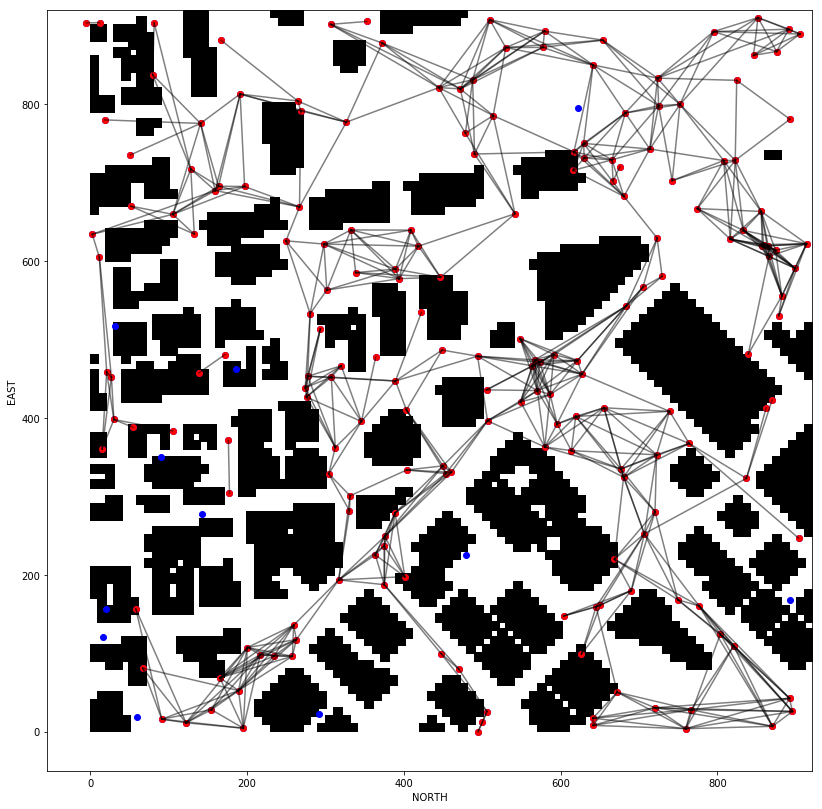

In [19]:
from grid import create_grid
grid = create_grid(data, sampler._zmax, 1)
fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower')

nmin = np.min(data[:, 0])
emin = np.min(data[:, 1])

# draw edges
for (n1, n2) in g.edges:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'black' , alpha=0.5)

# draw all nodes
for n1 in nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='blue')
    
# draw connected nodes
for n1 in g.nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='red')
    


plt.xlabel('NORTH')
plt.ylabel('EAST')

plt.show()

In [20]:
def heuristic(n1, n2):
    
    return LA.norm(np.array(n2) - np.array(n1))

In [21]:
def a_star(graph, heuristic, start, goal):
    """Modified A* to work with NetworkX graphs."""
    
    # TODO: complete

    path = []
    queue = PriorityQueue()
    queue.put((0, start))
    visited = set(start)

    branch = {}
    found = False
    
    while not queue.empty():
        item = queue.get()
        current_cost = item[0]
        current_node = item[1]

        if current_node == goal:        
            print('Found a path.')
            found = True
            break
        else:
            for next_node in graph[current_node]:
                cost = graph.edges[current_node, next_node]['weight']
                new_cost = current_cost + cost + heuristic(next_node, goal)
                
                if next_node not in visited:                
                    visited.add(next_node)               
                    queue.put((new_cost, next_node))
                    
                    branch[next_node] = (new_cost, current_node)
             
    path = []
    path_cost = 0
    if found:
        
        # retrace steps
        path = []
        n = goal
        path_cost = branch[n][0]
        while branch[n][1] != start:
            path.append(branch[n][1])
            n = branch[n][1]
        path.append(branch[n][1])
            
    return path[::-1], path_cost



In [22]:
start = list(g.nodes)[0]
k = np.random.randint(len(g.nodes))
print(k, len(g.nodes))
goal = list(g.nodes)[k]

89 195


In [23]:
path, cost = a_star(g, heuristic, start, goal)
print(len(path), path)

Found a path.
11 [(148.08973937753495, -418.0958159412973, 16.959069684763957), (294.6444268000719, -427.4544900660667, 5.974018147057761), (323.94601025709227, -436.5275968360615, 17.779674092277528), (379.68818363506915, -279.7964098284492, 5.814694288151219), (358.8508477701353, -172.20044888369574, 19.263196090367924), (466.91025422951367, -112.50001012906665, 9.070599301995554), (511.01249233196774, 5.498912717885844, 19.30513713257567), (562.013213234977, 90.85360864102984, 16.220089495136072), (571.5227139448216, 214.46278232508666, 0.23875337413704623), (489.6515730340208, 313.0335987116506, 15.767736638092824), (417.9736517359285, 368.77822985617934, 5.260244254756998)]


In [24]:
path_pairs = zip(path[:-1], path[1:])
for (n1, n2) in path_pairs:
    print(n1, n2)

(148.08973937753495, -418.0958159412973, 16.959069684763957) (294.6444268000719, -427.4544900660667, 5.974018147057761)
(294.6444268000719, -427.4544900660667, 5.974018147057761) (323.94601025709227, -436.5275968360615, 17.779674092277528)
(323.94601025709227, -436.5275968360615, 17.779674092277528) (379.68818363506915, -279.7964098284492, 5.814694288151219)
(379.68818363506915, -279.7964098284492, 5.814694288151219) (358.8508477701353, -172.20044888369574, 19.263196090367924)
(358.8508477701353, -172.20044888369574, 19.263196090367924) (466.91025422951367, -112.50001012906665, 9.070599301995554)
(466.91025422951367, -112.50001012906665, 9.070599301995554) (511.01249233196774, 5.498912717885844, 19.30513713257567)
(511.01249233196774, 5.498912717885844, 19.30513713257567) (562.013213234977, 90.85360864102984, 16.220089495136072)
(562.013213234977, 90.85360864102984, 16.220089495136072) (571.5227139448216, 214.46278232508666, 0.23875337413704623)
(571.5227139448216, 214.46278232508666, 

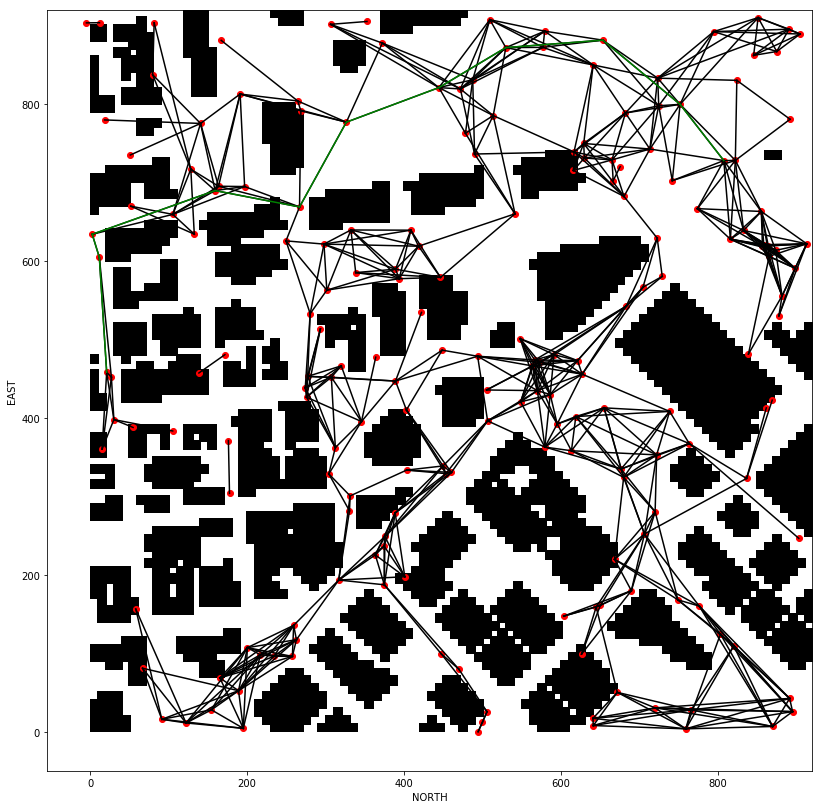

In [25]:
fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower')

nmin = np.min(data[:, 0])
emin = np.min(data[:, 1])

# draw nodes
for n1 in g.nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='red')
    
# draw edges
for (n1, n2) in g.edges:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'black')
    
# TODO: add code to visualize the path
path_pairs = zip(path[:-1], path[1:])
for (n1, n2) in path_pairs:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'green')


plt.xlabel('NORTH')
plt.ylabel('EAST')

plt.show()